In [1]:
import sys
from tqdm.auto import tqdm
sys.path.append('../code/')
import source
import importlib
importlib.reload(source)
from source.catalog import CatalogASCII
from source.skymap import PlanckMap, SquarePatch
from source.cosmology import CMBCosmology
import astropy.units as au
import healpy as hp
import numpy as np
from scipy.ndimage.filters import gaussian_filter

import matplotlib
import matplotlib
matplotlib.style.use('Minh_paper_style')
import matplotlib.pyplot as plt
from matplotlib.ticker import (FixedLocator, MultipleLocator, FixedFormatter, FormatStrFormatter,
                               AutoMinorLocator)

# Test the FFT-implementation of convolution

fft convolution:
map mean: -2.4424906541753444e-15 map rms: 83.76692502064776


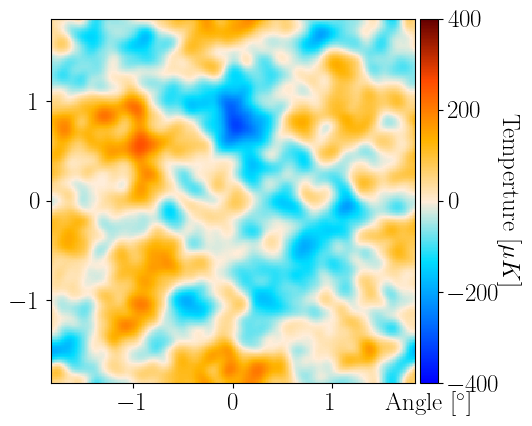

alm convolution:
map mean: -3.3306690738754696e-16 map rms: 83.76805790726415


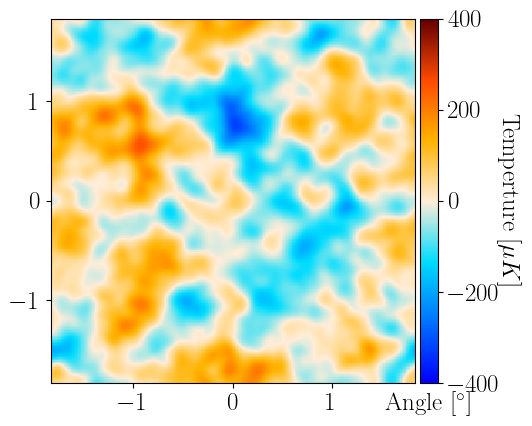

scipy convolution:
map mean: 8.881784197001252e-16 map rms: 86.58375139008307


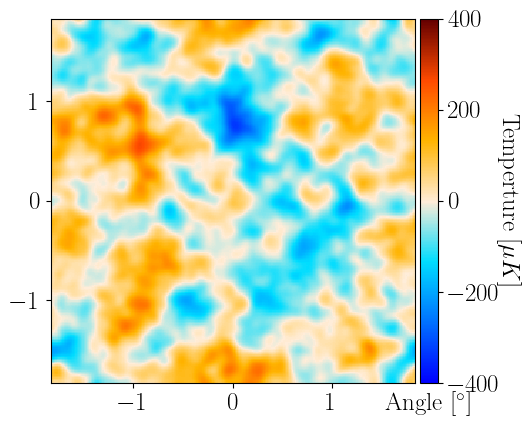

Difference between fft and alm convolution:
3.4932993997482953e-16
1.958348658198407e-05


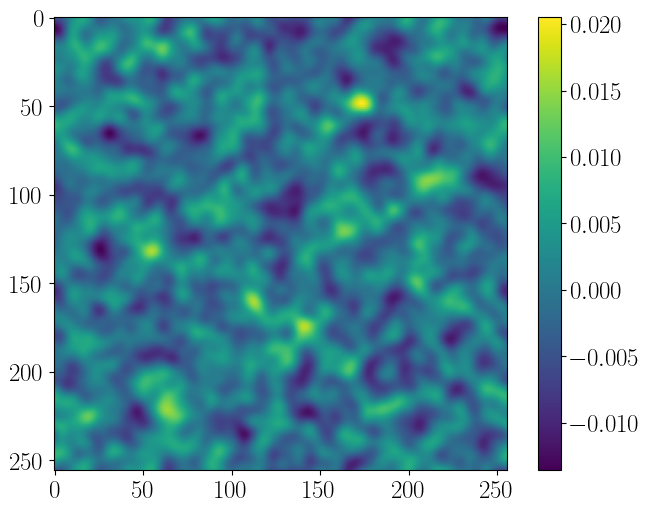

Difference between scipy and alm convolution:
1.6653345369377348e-16
37.15018996344686


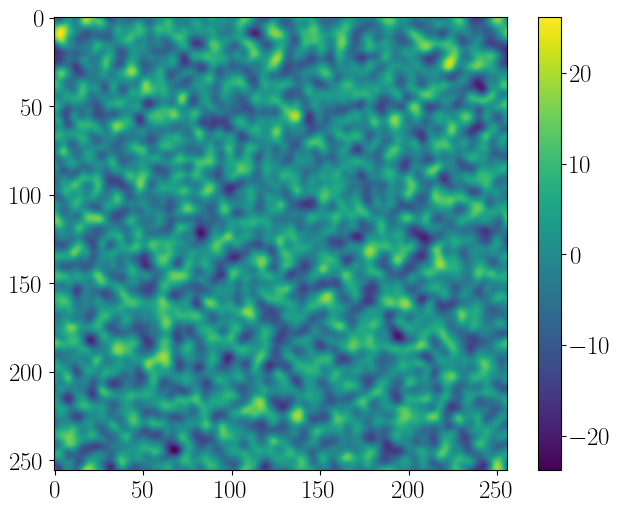

Difference between fft and scipy convolution:
2.42861286636753e-16
37.15775185463501


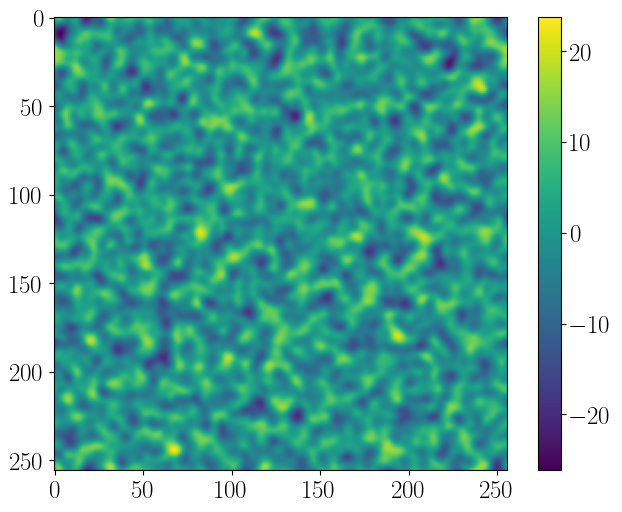

In [2]:
# Compare the different implementations of convolution

from source.cosmological_params import *
from source.map_params import *

N=int(512/2) # pixels per side
size=(14.66/2.) # degrees

# Set up the noise power spectrum
cosmo = CMBCosmology()
cosmo.get_Cl()
Bl = hp.gauss_beam((5.*au.arcmin).to_value(au.rad), lmax=camb_lmax_out)

# Prepare the 2D grid
cmb_unconvolved_sim = SquarePatch(patch_array=np.zeros((N,N)))
cmb_pixel_sim = SquarePatch(patch_array=np.zeros((N,N)))
cmb_alm_sim = SquarePatch(patch_array=np.zeros((N,N)))

# Simulate the patch
cmb_unconvolved_sim.simulate_CMB_patch(cosmo.CMBpower,seed=1)
cmb_pixel_sim.simulate_CMB_patch(cosmo.CMBpower,seed=1)
cmb_alm_sim.simulate_CMB_patch((Bl**2)*cosmo.CMBpower,seed=1)
beam_sigma = ( (5.*au.arcmin).to_value(au.arcmin) / (2*np.sqrt(2*np.log(2))) ) / ((size*au.deg).to_value(au.arcmin) / N)
cmb_Cl2D_convolved_pixel_scipy = gaussian_filter(cmb_pixel_sim.map, sigma=beam_sigma, order=0, mode='wrap',truncate=20.)
cmb_pixel_sim.convolve_gaussian(beam_size_fwhm=(5.*au.arcmin))
cmb_pixel_sim_scipy = SquarePatch(patch_array=cmb_Cl2D_convolved_pixel_scipy)

## Plot the patches
print("fft convolution:")
cmb_pixel_sim.plot_patch()
print("alm convolution:")
cmb_alm_sim.plot_patch()
print("scipy convolution:")
cmb_pixel_sim_scipy.plot_patch()
print("Difference between fft and alm convolution:")
diff = cmb_pixel_sim.map-cmb_alm_sim.map
print(np.mean(diff))
print(np.var(diff))
plt.imshow(diff)
plt.colorbar()
plt.show()
print("Difference between scipy and alm convolution:")
diff = cmb_pixel_sim_scipy.map-cmb_alm_sim.map
print(np.mean(diff))
print(np.var(diff))
plt.imshow(diff)
plt.colorbar()
plt.show()
print("Difference between fft and scipy convolution:")
diff = cmb_pixel_sim.map-cmb_pixel_sim_scipy.map
print(np.mean(diff))
print(np.var(diff))
plt.imshow(diff)
plt.colorbar()
plt.show()

# Test convolution with an input spherical beam kernel

map mean: -0.5743495653270769 map rms: 2.309648592716958


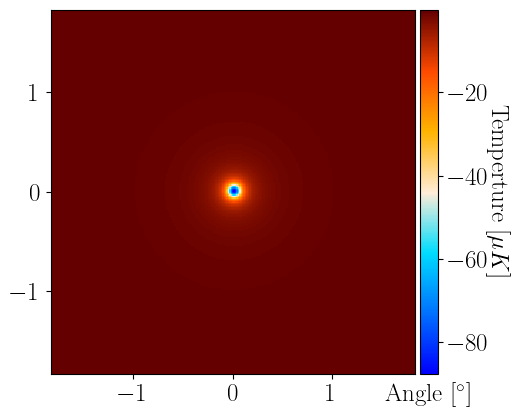

map mean: -0.5743495653270768 map rms: 2.3096565733320507


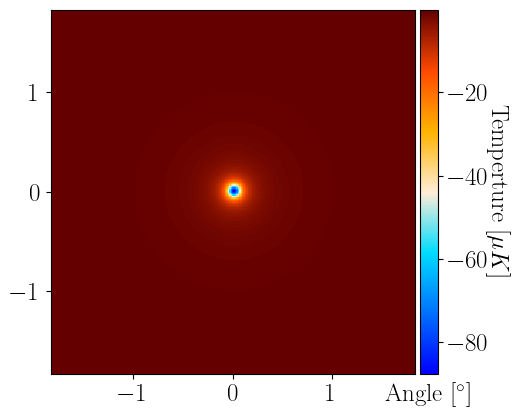

map mean: -1.0039458007331595e-17 map rms: 0.00036663854076949876


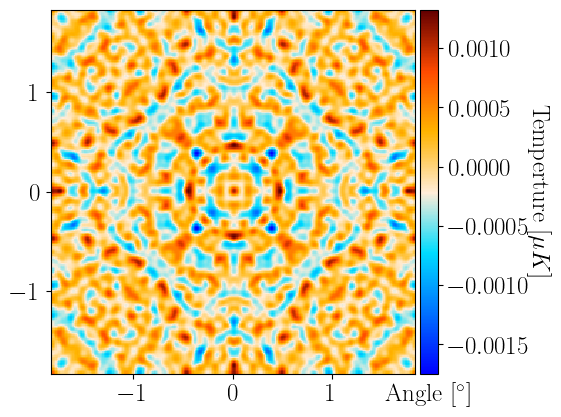

True

In [3]:
# Test patch with SZ signal

from source.cosmological_params import *
from source.map_params import *

test_patch_gaussian = SquarePatch(patch_array=np.zeros((N,N)),size_x=size,size_y=size)
test_patch_gaussian.simulate_SZ_source_beta(SZ_beta,SZ_theta_core=2.*au.arcmin)
#test_patch_gaussian.apodize_cos()
test_patch_gaussian.convolve_gaussian(beam_size_fwhm=9.*au.arcmin)
test_patch_gaussian.plot_patch(cmap_min=test_patch_gaussian.map.min(),cmap_max=test_patch_gaussian.map.max())

test_patch_gaussian_healpy = SquarePatch(patch_array=np.zeros((N,N)),size_x=size,size_y=size)
test_patch_gaussian_healpy.simulate_SZ_source_beta(SZ_beta,SZ_theta_core=2.*au.arcmin)
#test_patch_gaussian_healpy.apodize_cos()
Bl = hp.gauss_beam((9.*au.arcmin).to_value(au.rad), lmax=camb_lmax_out)
Bl_2d = test_patch_gaussian_healpy.construct_2d_multipole_kernel(Bl)
test_patch_gaussian_healpy.convolve(Bl)
test_patch_gaussian_healpy.plot_patch(cmap_min=test_patch_gaussian_healpy.map.min(),cmap_max=test_patch_gaussian_healpy.map.max())

diff = (test_patch_gaussian.map-test_patch_gaussian_healpy.map)
diff_patch = SquarePatch(patch_array=diff)
diff_patch.plot_patch(cmap_min=diff_patch.map.min(),cmap_max=diff_patch.map.max())

map mean: -6.106226635438361e-16 map rms: 92.9941561969032


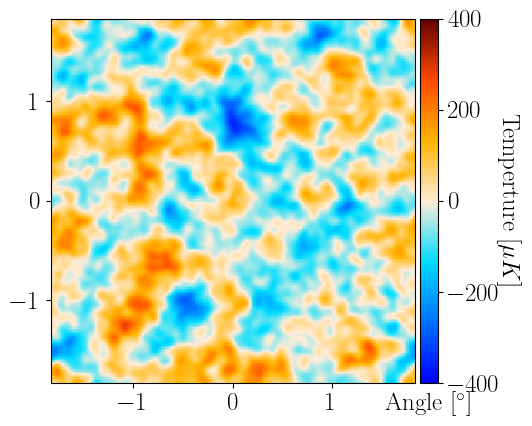

map mean: -1.27675647831893e-15 map rms: 92.99435688619727


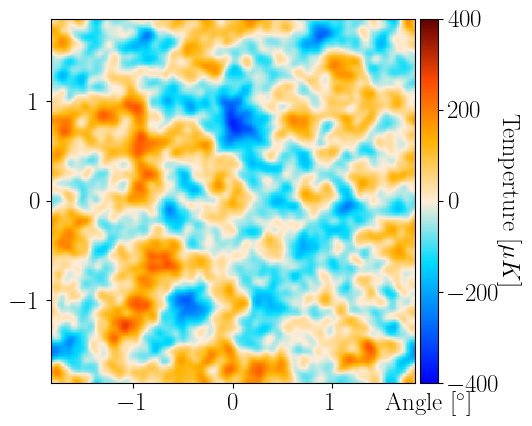

map mean: 4.219850380585144e-16 map rms: 0.0065482594382487895


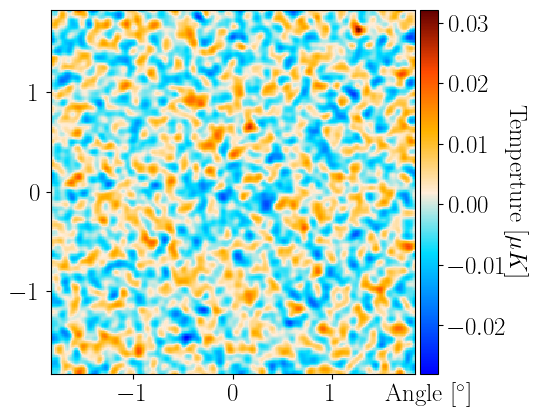

True

In [4]:
# Test patch with CMB noise

# Prepare the 2D grid
cmb_convolved_gaussian = SquarePatch(patch_array=np.zeros((N,N)),size_x=size,size_y=size)
cmb_convolved_input_beam = SquarePatch(patch_array=np.zeros((N,N)),size_x=size,size_y=size)

# Simulate the patch
cmb_convolved_gaussian_Cl2D = cmb_convolved_gaussian.simulate_CMB_patch(cosmo.CMBpower,seed=1)
cmb_convolved_input_beam_Cl2D = cmb_convolved_input_beam.simulate_CMB_patch(cosmo.CMBpower,seed=1)

# Convolve
#cmb_convolved_gaussian.apodize_cos()
#cmb_convolved_input_beam.apodize_cos()

cmb_convolved_gaussian.convolve_gaussian(beam_size_fwhm=(7.*au.arcmin))
Bl = hp.gauss_beam((7.*au.arcmin).to_value(au.rad), lmax=camb_lmax_out)
cmb_convolved_input_beam.convolve(Bl)

# Plot
cmb_convolved_gaussian.plot_patch()
cmb_convolved_input_beam.plot_patch()

diff = (cmb_convolved_gaussian.map-cmb_convolved_input_beam.map)
diff_patch = SquarePatch(patch_array=diff)
diff_patch.plot_patch(cmap_min=diff_patch.map.min(),cmap_max=diff_patch.map.max())